In [1]:
import os
import math
import random
import numpy as np
import random
import torch
import draw,utils
import warnings
warnings.filterwarnings("ignore")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']= '0'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    num_GPU = torch.cuda.device_count()
    print(f"GPU 数量: {num_GPU}")
print(f"运行平台: {device}")
root_path = os.path.abspath('.')

GPU 数量: 1
运行平台: cuda


In [3]:
# Field_filename = "F3"
# Field_filename = "Poseidon"
Field_filename = "Beagle"

if Field_filename == "F3": 
    num_sample = 540
elif Field_filename == "Poseidon": 
    num_sample = 638
elif Field_filename == "Beagle": 
    num_sample = 800
else:
    print("num_sample are none")
    
Valid_filename = "samples_"+Field_filename+"data.npy"
root_path = os.path.abspath(".")
dataset_name = 'field'
dataset_path = os.path.join(root_path, "dataset",dataset_name)
train_dataset_path = os.path.join(dataset_path, Field_filename+"_datasets_cigfacies")

if os.path.exists(os.path.join(dataset_path,Valid_filename)) is False:
    sample_name_list = []
    for i in range(num_sample):
        train_sample_file = f'{i}'
        sample_name_list.append(train_sample_file)
    num_data_sample = len(sample_name_list)
    samples_valid = []
    for sample_name in sample_name_list[:num_sample]:
        samples_valid.append(sample_name)
    
    np.save(os.path.join(dataset_path,Valid_filename), samples_valid)

samples_valid = np.load(os.path.join(dataset_path, Valid_filename), allow_pickle=True)
print(f"验证样本数量: {len(samples_valid)}")

train_sample_path = os.path.join(dataset_path, Field_filename+"_datasets_cigfacies")
input_attr_list, input_attr_list2 = ["seis"],["cigfacies"]
input_attr_list3, input_attr_list4 = ["slope"], ["normal"]
output_attr_list, output_attr_list2 =  ["label"], ["label"]

验证样本数量: 800


In [4]:
samples_valid = [samples_valid[0],samples_valid[100],samples_valid[200],
                 samples_valid[300],samples_valid[400],samples_valid[500],
                 samples_valid[600],samples_valid[700]]

valid_data =  utils.build_dataset_cigfacies(samples_valid, train_sample_path, 'Valid',
                                            input_attr_list=input_attr_list,input_attr_list2=input_attr_list2,
                                            output_attr_list=output_attr_list,output_attr_list2=output_attr_list2)

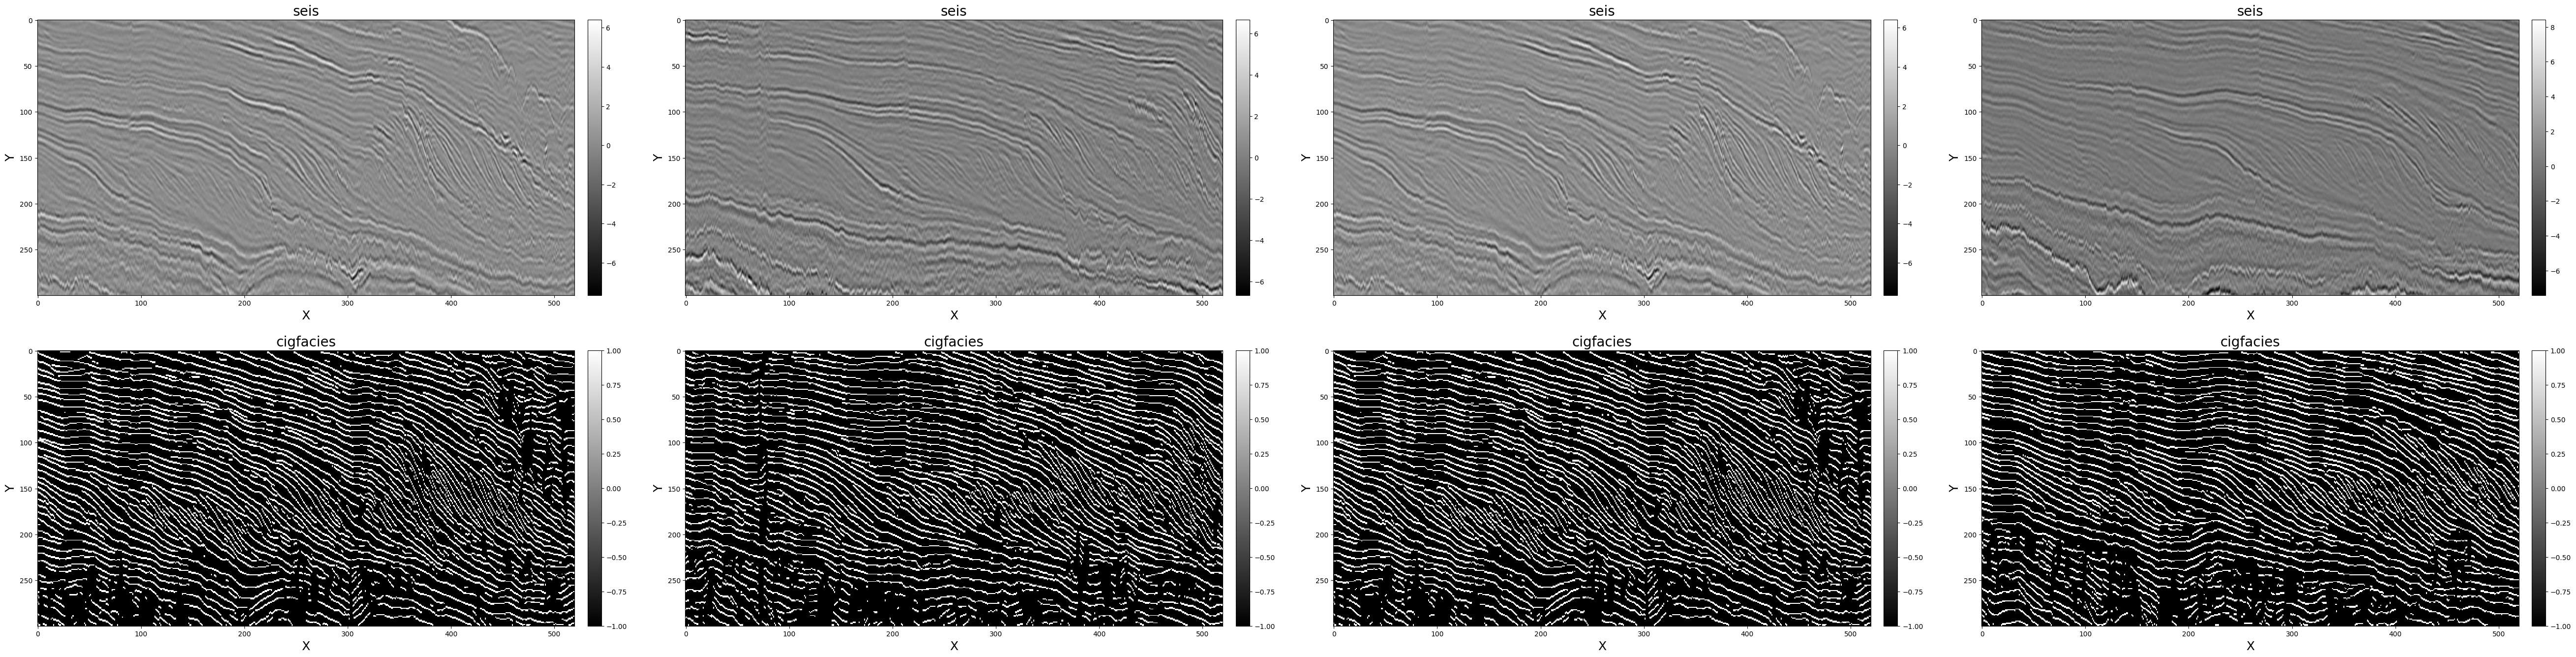

In [5]:
# plot
idxs = np.random.randint(0, len(valid_data), size=4) 
batch_samples = [valid_data[i] for i in idxs]
draw_attr_list = input_attr_list+ input_attr_list2
draw.draw_samples(batch_samples, draw_attr_list, cmap=["gray","gray"],methods=["bilinear","nearest"])

In [6]:
Modelname = "GLPmerge_cigfacies_L2SSIM"
# Modelname = "GLPmerge_cigfacies_L2SSIMCIGL1Norm"

from GLP.model import GLPDepth,GLPDepth_merge
# model = GLPDepth(max_depth=10,is_train=True)
model = GLPDepth_merge(max_depth=10,is_train=True)

# 并行模式
if torch.cuda.is_available():
    model = torch.nn.DataParallel(model, device_ids=range(num_GPU)).to(device)
else:
    model = model.to(device) 
    
# 模型保存路径    
checkpoint_path = os.path.join('checkpoints', Modelname)
print(f"模型读取路径: {checkpoint_path}")

model.load_state_dict(torch.load(os.path.join(checkpoint_path, 'checkpoint-best.pth'))['state_dict'])

/home/huig/anaconda3/envs/pytorch3d/lib/python3.9/site-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \


Loads checkpoint by local backend from path: ./GLP/weights/mit_b4.pth
The model and loaded state dict do not match exactly

size mismatch for patch_embed1.proj.weight: copying a param with shape torch.Size([64, 3, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 2, 7, 7]).
unexpected key in source state_dict: head.weight, head.bias

模型读取路径: ../seisfacies/checkpoints/GLPmerge_cigfacies_L2SSIM


<All keys matched successfully>

In [7]:
# 模型推理
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

# 归一化
def min_max_norm(x):
    if torch.is_tensor(x) and torch.max(x) != torch.min(x):
            x = x - torch.min(x)
            x = x / torch.max(x)        
    elif np.max(x) != np.min(x):
            x = x - np.min(x)
            x = x / np.max(x)
    return x

def pred(model, test_data, input_attrs, input_attrs2, output_attrs, output_attrs2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=False)
    
    model.eval()
    pred_samples = []
    with torch.no_grad():
        for batch_idx, batch_samples in enumerate(test_loader):
            data = batch_samples[input_attrs[0]].to(torch.float32).unsqueeze(1)
            data = Variable(data.to(device))
            
            data2 = batch_samples[input_attrs2[0]].to(torch.float32).unsqueeze(1)
            data2 = Variable(data2.to(device))
            
            target = batch_samples[output_attrs[0]].to(torch.float32)
            target = Variable(target.to(device))
            
            data  = torch.cat((data,data2), dim=1)
            target_i = model(data)
            
            
            target_i = target_i.cpu().numpy().squeeze(0)
            target = target.cpu().numpy().squeeze(0)
            data = data.cpu().numpy().squeeze(0)
            data2 = data2.cpu().numpy().squeeze(0)
            
            batch_samples["pred"] = target_i
            batch_samples["data"] = data[0]
            batch_samples["data2"] = data[1]
            batch_samples["label"] = target
            pred_samples.append(batch_samples)
    return pred_samples

In [8]:
pred_samples = pred(model, valid_data, input_attr_list, input_attr_list2, output_attr_list, output_attr_list2)

In [ ]:
import matplotlib.pyplot as plt
import random

def min_max_norm(x):
    x = x - np.min(x)
    x = x / np.max(x)
    return(x)

def Vis_Rgt_Curves(data, curves_num=10):
    rgt_min,rgt_max = np.min(data), np.max(data)
    xx = np.linspace(rgt_max,rgt_min,curves_num)
    rgt_line = np.zeros(data.shape)
    for j in range(data.shape[1]):
        for ni in range(curves_num):
            xi_arg = np.argmin(np.abs(data[:,j]-xx[ni]))
            xi_1,xi_2 = np.max((0,xi_arg-2)), np.min((data.shape[0]-2,xi_arg+1))
            rgt_line[xi_1:xi_2, j] = xx[ni]
    return rgt_line

# num = random.sample(range(0,5), 5)
# num = [0,1,2,3,4,5]
num = [3,4,5,6]

plt.figure(figsize=(10*len(num),24))
for ip in range(len(num)):
    seis = pred_samples[num[ip]]["data"].squeeze()
    seis2 = pred_samples[num[ip]]["data2"].squeeze()
    pred = pred_samples[num[ip]]["pred"].squeeze()
    pred = min_max_norm(pred) * 10
    
    plt.subplot(6,len(num),ip+1)
    plt.imshow(seis,cmap="gray",aspect="auto",interpolation="bilinear")
    plt.title("Seismic image <slices-"+str(num[ip])+">",fontsize=25)
    plt.colorbar(pad=0.01)
    
    plt.subplot(6,len(num),ip+1+len(num))
    plt.imshow(seis2,cmap="gray",aspect="auto",interpolation="nearest")
    plt.title("cigFacies <slices-"+str(num[ip])+">",fontsize=25)
    plt.colorbar(pad=0.01)
    
    plt.subplot(6,len(num),ip+1+len(num)*2)
    plt.imshow(pred,cmap=utils.getStrataColors(),aspect="auto",interpolation="bilinear")
    plt.title("Predicted RGT <slices-"+str(num[ip])+">",fontsize=25)
    plt.colorbar(pad=0.01)
    
    plt.subplot(6,len(num),ip+1+len(num)*3)
    curves = Vis_Rgt_Curves(pred,curves_num=41)
    plt.imshow(seis,cmap="gray",aspect="auto",interpolation="bilinear")
    plt.imshow(curves,cmap=utils.setAlpha("jet",FillExceptMin=True), aspect="auto",
               interpolation="nearest",alpha=0.8)
    plt.title("Overlap Seis-RGT <slices-"+str(num[ip])+">",fontsize=25)
    plt.colorbar(pad=0.01)
plt.tight_layout()